# RME analysis

Reynolds Mountain East simulation with wind redistribution of precipitation to form snow drifts. The drift evolution can be seen over the three images with the drifts lasting well into spring. The last plot is comparing the model pixel at the snow pillow site (red circle) to the model results. A descrepancy between meltout of the measured SWE and snow depth can be seen due to the snow depth measurement not being directly over the snow pillow. Therefore, without the pillow, the snowpack melts out about 10 days earlier due to differential melting.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import h5py
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_context('paper')

In [2]:
# Read in the model results
idx = [165, 200, 230]
nc = h5py.File('../output/rme/devel/wy2006/rme_longterm_2006/runs/run0000_5832/snow.nc', 'r')

mask_file = h5py.File('topo/topo.nc')
mask = mask_file['mask'][:]
mask_file.close()

swe = {}
for count,i in enumerate(idx):
    s = nc['specific_mass'][i,:]
    s[mask == 0] = np.nan # mask RME
    swe[count] = s

x = nc['x'][:]
y = nc['y'][:]
dates = pd.to_datetime('2005-10-01 00:00:00') + pd.to_timedelta(nc['time'][:], unit='h')
date_time = [dates[i].strftime('%B %d, %Y') for i in idx]


In [3]:
# Read in the pillow site data
meas_swe = pd.read_csv('station_data/RME_pillow_site.csv', parse_dates=True, index_col='date_time')

# measurement location, UTM 11
meas_location_x = 519970
meas_location_y = 4768100

# find the index in the model results
ind_x = np.argmin(np.abs(meas_location_x - x))
ind_y = np.argmin(np.abs(meas_location_y - y))

# meas_location_y
val = pd.DataFrame(index=dates)
val.index.name = 'date_time'
val['model_swe'] = nc['specific_mass'][:, ind_y, ind_x]
val['model_zs'] = nc['thickness'][:, ind_y, ind_x] * 100 # meters to cm
nc.close()

df = pd.concat([meas_swe, val], axis=1)
df.dropna(how='any', axis=0, inplace=True)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


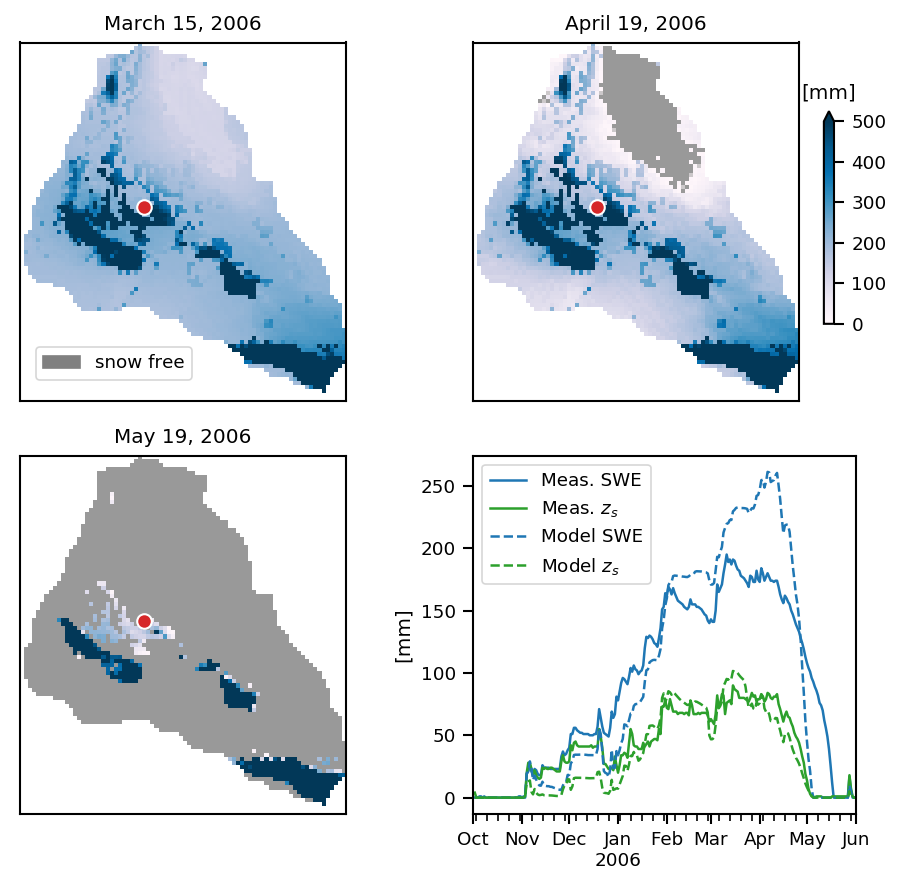

In [4]:
# create the colormap
colorsbad = plt.cm.Set1_r(np.linspace(0., 1, 1))
colors1 = plt.cm.PuBu(np.linspace(0, 1, 128))

colors = np.vstack((colorsbad, colors1))
cmap = mcolors.LinearSegmentedColormap.from_list('swe_colormap', colors)
cmap.set_bad('white',1.)

# Plot the figure
fig, ax = plt.subplots(figsize=(6, 6), dpi=150, nrows=2, ncols=2)

# RCEW basin SWE image
vmin = 0
vmax = 500
for key,data in swe.items():
    ix = np.unravel_index(key, ax.shape)
    s = ax[ix].imshow(data, vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    s.axes.get_xaxis().set_ticks([])
    s.axes.get_yaxis().set_ticks([])
    ax[ix].set_title(date_time[key])
    ax[ix].plot(ind_x, ind_y, 'o', markersize=7, markerfacecolor='C3',
             markeredgewidth=1.0, markeredgecolor='w')
    ax[ix].set_anchor('W')
    
    if key == 0:
        p = [patches.Patch(color='grey', label='snow free')]
        ax[ix].legend(handles=p, bbox_to_anchor=(0.05, 0.15),
                  loc=2, borderaxespad=0.)
               
# plot the pillow and the model
df.plot(ax=ax[1,1], color=['C0', 'C2', 'C0', 'C2'], style=['-', '-', '--', '--'])
ax[1,1].set_xlim('2005-10-01', '2006-06-01')
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('[mm]')
ax[1,1].legend(['Meas. SWE', 'Meas. $z_s$', 'Model SWE', 'Model $z_s$'])

# Add the colorbar  
cax = plt.axes([0.86, 0.5, 0.075, 0.5], visible=False)
cbar = plt.colorbar(s, ax=cax, extend='max', shrink=0.7, orientation='vertical')
cbar.ax.set_title('[mm]')

plt.tight_layout()

plt.savefig('rme_figure.png', dpi=200)